In [1]:
import pandas as pd
import numpy as np


%pylab inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score

%pylab inline
data=None
def absolute_correlations(col, df=data):
    #absolute_values = np.abs(df[col])
    corrs = pd.DataFrame(df.select_dtypes(include=[np.number]).corrwith(df[col]), columns=['correlation'])
    corrs['absol'] = np.abs(corrs['correlation'])
    return corrs.sort_values('absol', ascending=False).drop('absol', axis=1).tail(len(corrs)-1)

def numeric(self):
    '''Monkey-patches numeric features'''
    return self.select_dtypes(include=[np.number])
pd.DataFrame.numeric = numeric

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


In [2]:
# data = pd.DataFrame()

from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
data = pd.read_csv('magic_stompy2018.csv')
data = data[[i for i in data.columns if 'Unnamed' not in i]]

meta_stats = ['won', 'life', 'opponents_life', 'deck', 'deck_size', 'computer', 'starting_lands', 'opponents_level']
cards = [i for i in data.columns if i not in meta_stats]

In [4]:
# Timestamp
now = len(data)

# How close I got to winning
data.set_value(now, 'won', 1)
data.set_value(now, 'life', 14)
data.set_value(now, 'opponents_life', 0)
data.set_value(now, 'deck_size', 60)
data.set_value(now, 'starting lands', 2)
data.set_value(now, 'land rating', 3.5)

# creatures
data.set_value(now, 'drover of the mighty', 1)
data.set_value(now, 'druid of the cowl', 0)
data.set_value(now, 'feral prowler', 0)
data.set_value(now, 'dryad greenseeker', 0)
data.set_value(now, 'greenbelt rampager', 0)
data.set_value(now, 'llanowar elves', 3)
data.set_value(now, 'mouth', 0)
data.set_value(now, 'rishkar', 0)
data.set_value(now, 'steel life champion', 2)
data.set_value(now, 'thrashing brontodon', 0)
data.set_value(now, 'vine mare', 2)
data.set_value(now, 'walking ballista', 0)

# Artifacts
data.set_value(now, 'aethersphere harvester', 1)
data.set_value(now, 'lifecrafters bestiary', 0)
data.set_value(now, 'skysovereign', 0)
data.set_value(now, 'scrapheap scrounger', 0)

# Spells
data.set_value(now, 'blanchwood armor', 1)
data.set_value(now, 'blossoming defense', 1)
data.set_value(now, 'cartouche of strength', 0)
data.set_value(now, 'colossal majesty', 0)
data.set_value(now, 'natures way', 0)
data.set_value(now, 'plummet', 0)
data.set_value(now, 'rabid bite', 0)
data.set_value(now, 'rishkars expertise', 1)
data.set_value(now, 'savage stomp', 2)
data.set_value(now, 'song of freyalise', 0)
data.set_value(now, 'thunderherd migration', 1)
data.set_value(now, 'titanic growth', 0)

data.set_value(now, 'verdant rebirth', 0)
data.set_value(now, 'vivien reid', 0)

# Big boys
data.set_value(now, 'aggressive mamoth', 0)
data.set_value(now, 'ghalta', 0)
data.set_value(now, 'gigantosaurus', 0)
data.set_value(now, 'majestic myriarch', 0)
data.set_value(now, 'rhonas', 1)
data.set_value(now, 'scaled behemoth', 0)
data.set_value(now, 'shalai', 0)
data.set_value(now, 'verdurous gearhulk', 0)
data = data.fillna(0.)

data.to_csv('magic_stompy2018.csv')

In [58]:
data.mean()

won                        0.527273
life                       8.500000
opponents_life             8.963636
deck_size                 60.000000
starting lands             2.836364
druid of the cowl          0.109091
llanowar elves             0.890909
steel life champion        0.945455
vine mare                  0.818182
blanchwood armor           0.090909
lifecrafters bestiary      0.290909
natures way                0.127273
plummet                    0.236364
rabid bite                 0.545455
titanic growth             0.127273
verdant rebirth            0.200000
gigantosaurus              0.345455
majestic myriarch          0.127273
verdurous gearhulk         0.090909
scaled behemoth            0.090909
ghalta                     0.200000
land rating                3.009091
walking ballista           0.109091
colossal majesty           0.509091
aggressive mamoth          0.000000
rhonas                     0.327273
mouth                      0.000000
blossoming defense         0

In [16]:
# creatures = ['oketra', 'rhonas', 'serpopard', 'pacifist', 'baloth pup', 'mouth', 'croc',
# 'exemplar', 'defiant greatmaw', 'glorybound initiate', 'initiates companion',]

# removal = ['gideons reproach', 'reprisal', 'declare in stone', 'prepare']

# data['creatures_total'] = data[creatures].sum(axis=1)
# data['removal_total'] = data[removal].sum(axis=1)

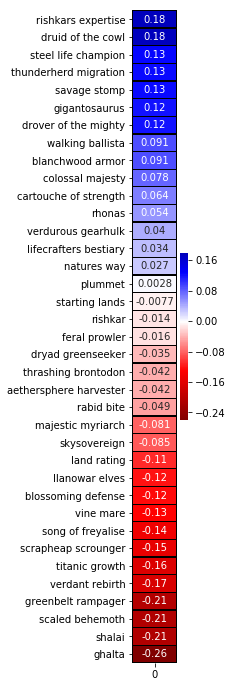

In [5]:
meta_stats = ['won', 'life', 'opponents_life', 'deck', 'deck_size', 'computer', 'starting_lands', 'opponents_level']
cards = [i for i in data.columns if i not in meta_stats]

winning_cards = data[cards].corrwith(data['won'])
winning_cards = pd.DataFrame(winning_cards).dropna().sort_values(0, ascending=False)

plt.figure(figsize=(1,12))

sns.heatmap(winning_cards,
           annot=True, cmap='seismic_r', linecolor='black',
           linewidths=.25, center=0)

In [6]:
from scipy import stats
sleep = []
for i in data.select_dtypes(include=[np.number]).drop(['life', 'opponents_life'], axis=1).columns:
    c = stats.pearsonr(data['won'], data[i])
    if c[1] < .15:
        if c[0] < .99:
            sleep.append([i, c[0], c[1]])


sleep = pd.DataFrame(sleep, columns=['card', 'corr', 'pvalue'])
sleep['absol'] = np.abs(sleep['corr'])

sleep.sort_values('absol', ascending=False).drop('absol', axis=1)

,card,corr,pvalue
1,ghalta,-0.260714,0.052293
3,shalai,-0.210771,0.118934
0,scaled behemoth,-0.210771,0.118934
2,greenbelt rampager,-0.206725,0.126349


In [7]:
cards = [
    'drover of the mighty',
    'druid of the cowl',
    'feral prowler',
    'dryad greenseeker',
    'greenbelt rampager',
    'llanowar elves',
    'mouth',
    'rishkar',
    'steel life champion',
    'thrashing brontodon',
    'vine mare',
    'walking ballista',
    'aethersphere harvester',
    'lifecrafters bestiary',
    'skysovereign',
    'scrapheap scrounger',
    'blanchwood armor',
    'blossoming defense',
    'cartouche of strength',
    'colossal majesty',
    'natures way',
    'plummet',
    'rabid bite',
    'song of freyalise',
    'titanic growth',
    'verdant rebirth',
    'vivien reid',
    'aggressive mamoth',
    'ghalta',
    'gigantosaurus',
    'majestic myriarch',
    'rhonas',
    'scaled behemoth',
    'shalai',
    'verdurous gearhulk',
]

In [8]:
combinations = pd.DataFrame()

for i in cards:
    for j in cards:
        if i > j:
            combinations[i + ' + ' + j] = data[i] + data[j]

In [9]:
from scipy import stats
sleep = []
for i in combinations.columns:
    c = stats.pearsonr(data['won'], combinations[i])
    if c[1] < .1:
        if c[0] < .99:
            sleep.append([i, c[0], c[1]])


sleep = pd.DataFrame(sleep, columns=['card', 'corr', 'pvalue'])
sleep['absol'] = np.abs(sleep['corr'])

sleep.sort_values('absol', ascending=False).drop('absol', axis=1)

,card,corr,pvalue
22,scaled behemoth + ghalta,-0.362329,0.006066
0,greenbelt rampager + ghalta,-0.336202,0.011297
25,shalai + ghalta,-0.334259,0.011808
26,shalai + scaled behemoth,-0.313857,0.018494
11,titanic growth + ghalta,-0.308946,0.020515
6,song of freyalise + ghalta,-0.299183,0.025093
23,shalai + greenbelt rampager,-0.297733,0.025842
15,verdant rebirth + ghalta,-0.291456,0.029300
5,scrapheap scrounger + ghalta,-0.287904,0.031423
17,verdant rebirth + shalai,-0.283069,0.034518


In [ ]:
# Machine learning

In [12]:
x = data[cards]
y = data['won']

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score

kf = StratifiedKFold(n_splits=3)

param_grid = {
    'max_depth': np.arange(2,21),
    'min_samples_leaf': [1,2,3,4,5,10],
    'min_samples_split': np.arange(2,6),
}

clf = DecisionTreeClassifier()

grid = GridSearchCV(clf, param_grid=param_grid, cv=kf, scoring='roc_auc').fit(x, y)
clf = grid.best_estimator_

clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [13]:
cv = cross_val_score(clf, x, y, cv=kf, scoring='roc_auc')

print('Mean:', cv.mean())
print('Std dev:', cv.std())

Mean: 0.6032407407407407
Std dev: 0.0465410198587488


# Template

In [ ]:
# Timestamp
now = len(data)

# How close I got to winning
data.set_value(now, 'won', )
data.set_value(now, 'life', )
data.set_value(now, 'opponents_life', )
data.set_value(now, 'deck_size', 60)
data.set_value(now, 'starting lands', )
data.set_value(now, 'land rating', )

# creatures
data.set_value(now, 'drover of the mighty', 0)
data.set_value(now, 'druid of the cowl', 0)
data.set_value(now, 'feral prowler', 0)
data.set_value(now, 'dryad greenseeker', 0)
data.set_value(now, 'greenbelt rampager', 0)
data.set_value(now, 'llanowar elves', 0)
data.set_value(now, 'mouth', 0)
data.set_value(now, 'rishkar', 0)
data.set_value(now, 'steel life champion', 0)
data.set_value(now, 'thrashing brontodon', 0)
data.set_value(now, 'vine mare', 0)
data.set_value(now, 'walking ballista', 0)

# Artifacts
data.set_value(now, 'aethersphere harvester', 0)
data.set_value(now, 'lifecrafters bestiary', 0)
data.set_value(now, 'skysovereign', 0)
data.set_value(now, 'scrapheap scrounger', 0)

# Spells
data.set_value(now, 'blanchwood armor', 0)
data.set_value(now, 'blossoming defense', 0)
data.set_value(now, 'cartouche of strength', 0)
data.set_value(now, 'colossal majesty', 0)
data.set_value(now, 'natures way', 0)
data.set_value(now, 'plummet', 0)
data.set_value(now, 'rabid bite', 0)
data.set_value(now, 'rishkars expertise', 0)
data.set_value(now, 'savage stomp', 0)
data.set_value(now, 'song of freyalise', 0)
data.set_value(now, 'thunderherd migration', 0)
data.set_value(now, 'titanic growth', 0)

data.set_value(now, 'verdant rebirth', 0)
data.set_value(now, 'vivien reid', 0)

# Big boys
data.set_value(now, 'aggressive mamoth', 0)
data.set_value(now, 'ghalta', 0)
data.set_value(now, 'gigantosaurus', 0)
data.set_value(now, 'majestic myriarch', 0)
data.set_value(now, 'rhonas', 0)
data.set_value(now, 'scaled behemoth', 0)
data.set_value(now, 'shalai', 0)
data.set_value(now, 'verdurous gearhulk', 0)
data = data.fillna(0.)

data.to_csv('magic_stompy2018.csv')